In [183]:
import numpy as np
import tensorflow as tf

# Get the MNIST Data
mnist = tf.keras.datasets.mnist

In [186]:
n_qubits = 6                  # Number of qubits
num_layers = 5                # Number of layers

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print(len(x_train), len(y_test))
print(x_train.shape)

reduce_scale = 5
select_digits = [1, 3, 6]

if select_digits:
  train_index_f = (y_train == -1)
  tests_index_f = (y_test  == -1)
  
  for n_class in select_digits:
    train_index_f   |= (y_train == n_class) 
    tests_index_f   |= (y_test == n_class)
  x_train = x_train[train_index_f]
  y_train = y_train[train_index_f]

  x_test = x_test[tests_index_f]
  y_test = y_test[tests_index_f]

if reduce_scale:
  x_train = x_train[:int(len(x_train)/reduce_scale)]
  y_train = y_train[:int(len(y_train)/reduce_scale)]

  x_test = x_test[:int(len(x_test)/reduce_scale)]
  y_test = y_test[:int(len(y_test)/reduce_scale)]

60000 10000
(60000, 28, 28)


In [188]:
latent_dim = 2 ** n_qubits    # Selected latent dimensions

class Autoencoder(tf.keras.models.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Flatten(name = "faltten_1"),
      tf.keras.layers.Dense(128, activation='relu', name = "dense_1"),
      tf.keras.layers.Dense(64, activation='relu', name = "dense_2"),
      tf.keras.layers.Dense(64, activation='relu', name = "dense_x"),
      tf.keras.layers.Dense(latent_dim, activation='relu', name = "dense_3"),
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu', name = "dense_4"),
      tf.keras.layers.Dense(128, activation='relu', name = "dense_5"),
      tf.keras.layers.Dense(784, activation='sigmoid', name = "dense_6"),
      tf.keras.layers.Reshape((28, 28), name = "reshape_1")
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Prepare and compile the model
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss='mae', metrics=["accuracy"])

# Train the model with the filtered data
autoencoder.fit(x_train, x_train, epochs=50, shuffle=True, validation_data=(x_test, x_test))


Epoch 1/50
118/118 [==============================] - 1s 5ms/step - loss: 0.1543 - accuracy: 0.1227 - val_loss: 0.1017 - val_accuracy: 0.1410
Epoch 2/50
118/118 [==============================] - 0s 3ms/step - loss: 0.1086 - accuracy: 0.1119 - val_loss: 0.0961 - val_accuracy: 0.1281
Epoch 3/50
118/118 [==============================] - 0s 3ms/step - loss: 0.0993 - accuracy: 0.1286 - val_loss: 0.0867 - val_accuracy: 0.1517
Epoch 4/50
118/118 [==============================] - 0s 3ms/step - loss: 0.0918 - accuracy: 0.1534 - val_loss: 0.0833 - val_accuracy: 0.1589
Epoch 5/50
118/118 [==============================] - 0s 3ms/step - loss: 0.0851 - accuracy: 0.1745 - val_loss: 0.0762 - val_accuracy: 0.1957
Epoch 6/50
118/118 [==============================] - 0s 3ms/step - loss: 0.0769 - accuracy: 0.1950 - val_loss: 0.0705 - val_accuracy: 0.2007
Epoch 7/50
118/118 [==============================] - 0s 3ms/step - loss: 0.0718 - accuracy: 0.2006 - val_loss: 0.0672 - val_accuracy: 0.2096
Epoch 

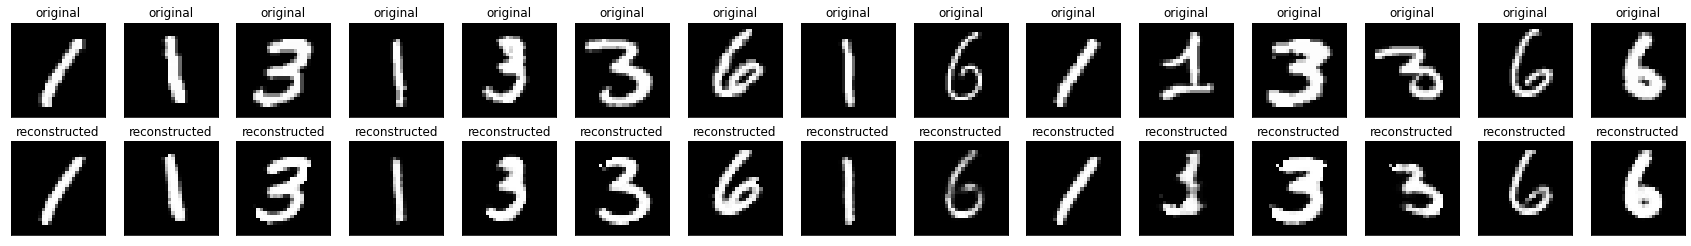

In [189]:
import matplotlib.pyplot as plt

encoded_imgs = autoencoder.encoder(x_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 15
plt.figure(figsize=(30, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [190]:
# Encode data with our new autoencoder
QX_train = autoencoder.encoder(x_train).numpy()
QX_test = autoencoder.encoder(x_test).numpy()

# Change Y values to categorical
QY_train = tf.keras.utils.to_categorical(y_train, 10)
QY_test = tf.keras.utils.to_categorical(y_test, 10)

In [191]:
import pennylane as qml
from pennylane import numpy as p_np

from pennylane.templates.state_preparations import MottonenStatePreparation
from pennylane.templates.layers import StronglyEntanglingLayers

In [192]:
dev = qml.device("default.qubit", wires = n_qubits)

@qml.qnode(dev, diff_method='adjoint')
def circuit(weights, inputs=None):
  ''' Quantum QVC Circuit'''

  # Splits need to be done through the tensorflow interface
  weights_each_layer = tf.split(weights, num_or_size_splits=num_layers, axis=0)
  
  # Input normalization
  inputs_1 = inputs / p_np.sqrt(max(p_np.sum(inputs ** 2, axis=-1), 0.001))

  for i, W in enumerate(weights):
    # Data re-uploading technique
    if i % 2 == 0:
      MottonenStatePreparation(inputs_1, wires = range(n_qubits))
    
    # Neural network layer
    StronglyEntanglingLayers(weights_each_layer[i], wires=range(n_qubits))
  
  # Measurement return
  return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)] 

In [193]:
weight_shapes = {"weights": (num_layers,n_qubits,3)}

# Model  
input_m = tf.keras.layers.Input(shape=(2 ** n_qubits,), name = "input_0")
keras_1 = qml.qnn.KerasLayer(circuit, weight_shapes, output_dim=n_qubits, name = "keras_1")(input_m)
output = tf.keras.layers.Dense(10, activation='softmax', name = "dense_1")(keras_1)

# Model creation
model = tf.keras.Model(inputs=input_m, outputs=output, name="mnist_quantum_model")

# Model compilation
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01) ,
  metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [211]:
model.summary()

Model: "mnist_quantum_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_0 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
keras_1 (KerasLayer)         (None, 6)                 90        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                70        
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


In [194]:
model.fit(QX_train, QY_train, batch_size=8, epochs=5, shuffle=True)

Epoch 1/5
470/470 [==============================] - 1770s 4s/step - loss: 0.6561 - categorical_accuracy: 0.8651
Epoch 2/5
470/470 [==============================] - 1734s 4s/step - loss: 0.1389 - categorical_accuracy: 0.9755
Epoch 3/5
470/470 [==============================] - 1640s 3s/step - loss: 0.0933 - categorical_accuracy: 0.9790
Epoch 4/5
470/470 [==============================] - 49847s 106s/step - loss: 0.0730 - categorical_accuracy: 0.9824
Epoch 5/5
470/470 [==============================] - 1633s 3s/step - loss: 0.0665 - categorical_accuracy: 0.9811


In [195]:
results = model.evaluate(QX_test, QY_test)

20/20 [==============================] - 82s 4s/step - loss: 0.0976 - categorical_accuracy: 0.9694


In [196]:
predicted = model.predict(QX_test)

In [197]:
from collections import Counter
predicted_argmax = np.argmax(predicted, axis=1)
incorrect = predicted_argmax != y_test
print(Counter(y_test[incorrect]))

Counter({3: 13, 6: 5, 1: 1})


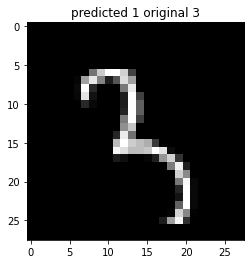

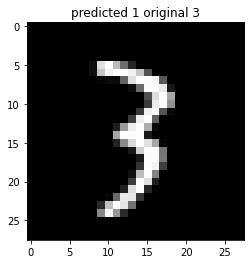

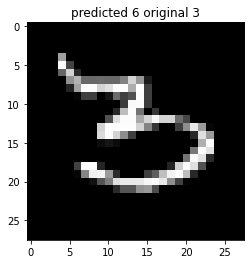

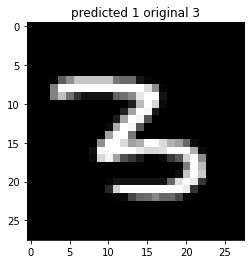

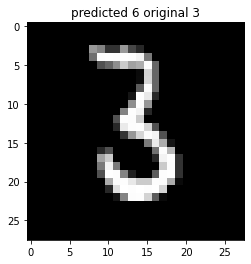

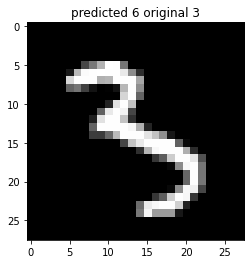

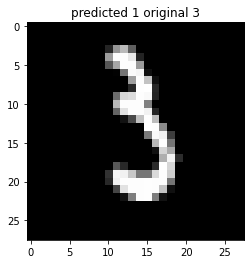

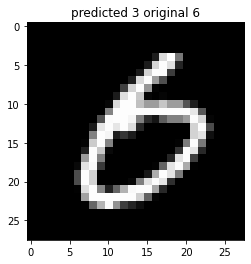

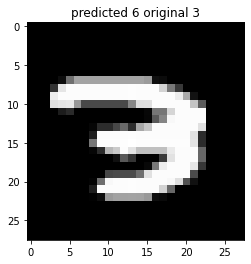

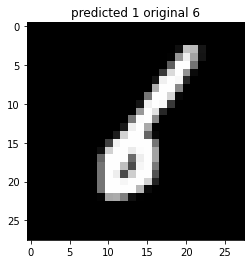

In [198]:
count = 10
x_t = x_test[incorrect][:count]
y_t = y_test[incorrect][:count]
p_t = predicted_argmax[incorrect][:count]

for x,y,p in zip(x_t, y_t, p_t):
    plt.imshow(x)
    plt.title(f"predicted {p} original {y}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


Build | Autoencoder | Train | Test
--- | --- | --- | ---
2 qubits 1 layer | 19% | 23m 51% | 56%


In [230]:
classical_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
classical_model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01) ,
  metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

classical_model.fit(QX_train, QY_train, epochs=5, batch_size=8, shuffle=True)

print(classical_model.summary())

Epoch 1/5
470/470 [==============================] - 1s 565us/step - loss: 0.7766 - categorical_accuracy: 0.7073
Epoch 2/5
470/470 [==============================] - 0s 514us/step - loss: 0.2989 - categorical_accuracy: 0.9303
Epoch 3/5
470/470 [==============================] - 0s 544us/step - loss: 0.2317 - categorical_accuracy: 0.9377
Epoch 4/5
470/470 [==============================] - 0s 525us/step - loss: 0.2083 - categorical_accuracy: 0.9409
Epoch 5/5
470/470 [==============================] - 0s 512us/step - loss: 0.1830 - categorical_accuracy: 0.9452
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 2)                 130       
_________________________________________________________________
dense_78 (Dense)             (None, 10)                30        
Total params: 160
Trainable params: 160
Non-trainable params: 0
__________________

In [231]:
classical_model.evaluate(QX_test, QY_test)

20/20 [==============================] - 0s 526us/step - loss: 0.2157 - categorical_accuracy: 0.9403


[0.21574212610721588, 0.9403225779533386]

In [232]:
classical_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(n_qubits*3, activation='relu'),
  tf.keras.layers.Dense(n_qubits*3, activation='relu'),
  tf.keras.layers.Dense(n_qubits*3, activation='relu'),
  tf.keras.layers.Dense(n_qubits*3, activation='relu'),
  tf.keras.layers.Dense(n_qubits*3, activation='relu'),
  tf.keras.layers.Dense(n_qubits*3, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
classical_model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01) ,
  metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

classical_model.fit(QX_train, QY_train, epochs=5, batch_size=8, shuffle=True)

print(classical_model.summary())

Epoch 1/5
470/470 [==============================] - 1s 889us/step - loss: 0.2110 - categorical_accuracy: 0.9351
Epoch 2/5
470/470 [==============================] - 0s 962us/step - loss: 0.1018 - categorical_accuracy: 0.9705
Epoch 3/5
470/470 [==============================] - 0s 1ms/step - loss: 0.0900 - categorical_accuracy: 0.9782
Epoch 4/5
470/470 [==============================] - 1s 1ms/step - loss: 0.1342 - categorical_accuracy: 0.9635
Epoch 5/5
470/470 [==============================] - 1s 1ms/step - loss: 0.0755 - categorical_accuracy: 0.9782
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 18)                1170      
_________________________________________________________________
dense_80 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_81 (Dense)      

In [233]:
classical_model.evaluate(QX_test, QY_test)

20/20 [==============================] - 0s 579us/step - loss: 0.1232 - categorical_accuracy: 0.9613


[0.12318307161331177, 0.9612902998924255]